# Agent Based Hydrology Simulation

This project examines how well Reinforcement Learning (RL) algorithms can optimize a Constant Elasticity of Substitution
(CES) production function within an Agent Based Model (ABM). A CES production function is an economic production function that essentially maps from inputs
to output where there is some substitutability between inputs<sup>1</sup>. In this simulation, the inputs are land and water, while the output is the crop yield.

With this goal as the basis of the simulation, we can break down the agent based model into the following components.

Reinforcement Learning Agent
1. Learning algorithm
2. Action-value function

Environment Model
1. Hydrology function
2. Production/reward function

## Reinforcement Learning Agent

The reinforcement learning agent has two primary components. The first component of this is the learning algorithm. This algorithm controls how the agent explores and learns from the simulation environment. I chose Deep-Q learning<sup>2</sup> which explores the environment and collecting memory tuples:
$ (State_t, Action_t, Reward_t, State_{t+1}, Action_{t+1}) $ These memories are used to optimize the other component of
the RL agent called the action-value function. The action-value function maps from the observed state of the environment to the value of each action. The action-value function is optimized by minimizing the difference between the estimated value, and actual value of that state which is bootstrapped actual reward and estimated value of the next state. The memories are sampled with a probability proportional to this error so that the agent focuses on values it estimated poorly.<sup>3</sup>

In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import namedtuple, deque

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LEARNING_RATE = 1e-4
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 50
UPDATE_EVERY = 4
GAMMA = 0.99
BETA = 0.0
TAU = 1e-3


class Agent:
    """Deep-Q Agent with prioritized replay buffer"""

    def __init__(self, state_size, action_size, seed):

        """
        Initializes Agent.
        """
        self.action_size = action_size

        # Q-Network
        self.qnetwork_local = Actor(state_size, action_size, seed).to(device)
        self.qnetwork_target = Actor(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LEARNING_RATE)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

        # epsilon decay
        self.eps = 1.0
        self.eps_end = 0.1
        self.eps_decay = 0.995

    def step(self, state, action, reward, next_state, done):
        """
        Saves experience in the replay buffer and decides if the network needs to be updated.

        Args:
            state: (tuple) state vector
            action: (tuple) action vector
            reward: (float) reward scalar
            next_state: (tuple) next state vector
            done: (bool) defines if state is terminal
        """
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.1):

        """
        Chooses an action with epsilon greedy policy.

        Args:
            state: (tuple) state vector
            eps: (float) epsilon value

        Returns:
            int: action index
        """
        max_yearly_water = state[1]
        max_land = state[2]
        state = torch.from_numpy(state).float().to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        water_values = action_values[0].cpu().data.numpy()
        land_values = action_values[1].cpu().data.numpy()

        water_action = np.argmax(water_values) / 100
        land_action = np.argmax(land_values) / 100

        max_water_land = np.array((max_yearly_water, max_land))

        self.eps = max(self.eps_end, self.eps * self.eps_decay)
        # Epsilon-greedy action selection
        if random.random() > self.eps:
            return np.array(water_action, land_action) * max_water_land
        else:
            return np.random.randint(0, 101, 2) / 100 * max_water_land

    def learn(self, experiences, gamma):
        # type: (tuple, float) -> None
        """
        Up date the model weights and the resulting priorities in the replay buffer.

        Args:
            experiences: (tuple) tuple of np.vstacks, data for supervised learning
            gamma: (float) expected future reward discount factor
        """
        states, actions, rewards, next_states, dones, probabilities = experiences

        sampling_weight = (1/BUFFER_SIZE * 1/probabilities) ** BETA / probabilities.squeeze().max(0)[0]

        # get action value for the chosen action
        Q_target_undiscounted = self.qnetwork_target(next_states).detach().max(2)[0].unsqueeze(2)

        # then sum the value of the water and land heads
        Q_target_undiscounted = torch.sum(Q_target_undiscounted, dim=0)

        Q_target = rewards + (gamma * Q_target_undiscounted * (1 - dones))

        Q_estimate = self.qnetwork_local(states).max(2)[0].unsqueeze(2)
        Q_estimate = torch.sum(Q_estimate, dim=0)

        loss = F.mse_loss(sampling_weight * Q_estimate, sampling_weight * Q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

        # update the probabilities with new td_errors
        td_error = Q_target - Q_estimate
        self.memory.update(states, actions, rewards, next_states, dones, td_error)

    def soft_update(self, local_model, target_model, tau):
        # type: (torch.nn.Module, torch.nn.Module, float) -> None
        """
        Weighted update of local model parameters.

        θ_target = tau*θ_local + (1 - tau)*θ_target

        Args:
            local_model: (torch.nn.Module) weights will be copied from
            target_model: (torch.nn.Module) weights will be copied to
            tau: (float) interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)



class ReplayBuffer:
    """Fixed-size prioritized buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, eta=1e-5, prob_temp=0.5, temp_decay=1e-5):
        # type: (int, int, int, int, float, float, float) -> None
        """
        Initialize a ReplayBuffer object.

        Args:
            action_size: (int) dimension of each action
            buffer_size: (int) maximum size of buffer
            batch_size: (int) size of each training batch
            seed: (int) random seed
        """
        self.action_size = action_size
        self.batch_size = batch_size
        self.seed = np.random.seed(seed)
        self.eta = eta
        self.prob_temp = prob_temp
        self.temp_decay = temp_decay
        self.indexes = np.zeros(batch_size)

        self.memory = deque(maxlen=buffer_size)
        self.priority_memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience",
                                     field_names=["state", "action", "reward", "next_state", "done", "priority"])

    def add(self, state, action, reward, next_state, done):
        # type: (tuple, int, float, tuple, bool) -> None
        """
        Compute priority and add new experience to replay buffer.

        Args:
            state: (tuple) state vector
            action: (int) action index
            reward: (float) reward scalar
            next_state: (tuple) next state vector
            dones: (bool) indicates if state is terminal
            td_error: (float) used to update priority in buffer
        """

        priority = max(self.priority_memory) if len(self.memory) > 0 else 0.1
        e = self.experience(state, action, reward, next_state, done, priority)
        self.memory.append(e)
        self.priority_memory.append(priority)

    def sample(self):
        """
        Select experiences with priority probability.

        Returns:
            states: (torch.tensor) sample state tensor
            actions: (torch.tensor) sample actions tensor
            rewards: (torch.tensor) sample rewards tensor
            next_states: (torch.tensor) sample next state tensor
            dones: (torch.tensor) sample dones tensor
            priority_prob: (torch.tensor) sample priority tensor
        """

        self.prob_temp = max(0, (self.prob_temp - self.temp_decay))
        priority_array = np.array(self.priority_memory)

        priority_probability = (priority_array ** self.prob_temp) / np.sum(priority_array ** self.prob_temp)
        self.indexes = np.random.choice(np.arange(0, len(self.memory)), size=self.batch_size, replace=False, p=priority_probability)

        experiences = [self.memory[i] for i in self.indexes]
        filtered_probabilities = priority_probability[self.indexes]

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        priority_prob = torch.from_numpy(np.vstack([p for p in filtered_probabilities if p is not None])).float().to(device)

        return states, actions, rewards, next_states, dones, priority_prob

    def update(self, state, action, reward, next_state, dones, td_error):
        # type: (torch.tensor, torch.tensor, torch.tensor, torch.tensor, torch.tensor, torch.tensor, float) -> None
        """Use TD errors to change values for respective tuples in replay buffer

        Args:
            state: (torch.tensor) state vector
            action: (torch.tensor) action index
            reward: (torch.tensor) reward scalar
            next_state: (torch.tensor) next state vector
            dones: (torch.tensor) indicates if state is terminal
            td_error: (float) used to update priority in buffer
        """
        priority = (torch.abs(reward + td_error) + self.eta)

        for i, index in enumerate(self.indexes):
            self.memory[index] = self.experience(state[i].cpu().numpy(),
                                                 action[i].cpu().numpy(),
                                                 reward[i].cpu().numpy(),
                                                 next_state[i].cpu().numpy(),
                                                 dones[i].cpu().numpy(),
                                                 priority[i].cpu().item(),
                                                 )
            self.priority_memory[index] = priority[i].item()

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Actor(nn.Module):
    """Actor, Action-Value function."""

    def __init__(self, state_size, action_size, seed, fc_units=256):
        """
        Initialize parameters and build model.

        Args:
            state_size (int): Dimension of state space
            action_size (int): Dimension of action space
            seed (int): Random seed
            fc_units (int): Hidden layer dimension
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed) if seed is not None else None

        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, fc_units)

        self.fc_water_head_1 = nn.Linear(fc_units, fc_units)
        self.fc_water_head_2 = nn.Linear(fc_units, action_size)

        self.fc_land_head_1 = nn.Linear(fc_units, fc_units)
        self.fc_land_head_2 = nn.Linear(fc_units, action_size)

        self.dropout_1 = nn.Dropout(p=0.25)
        self.dropout_2 = nn.Dropout(p=0.25)
        self.dropout_3 = nn.Dropout(p=0.25)
        self.dropout_4 = nn.Dropout(p=0.25)

        self.reset_parameters()

    def reset_parameters(self):
        """
        Initializes network weights using uniform distribution rather than Gaussian.
        """
        self.fc1.weight.data.uniform_(-3e-3, 3e-3)
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

        self.fc_water_head_1.weight.data.uniform_(-3e-3, 3e-3)
        self.fc_water_head_2.weight.data.uniform_(-3e-3, 3e-3)

        self.fc_land_head_1.weight.data.uniform_(-3e-3, 3e-3)
        self.fc_land_head_2.weight.data.uniform_(-3e-3, 3e-3)


    def forward(self, state):
        """
        Maps states -> action values

        Args:
            state vector (torch.tensor):
            [batch, available_water, max_water, available_land, crop_price]
        """

        x1 = self.dropout_1(F.relu(self.fc1(state)))
        x2 = self.dropout_2(F.relu(self.fc2(x1)))

        x_water = self.dropout_3(F.relu(self.fc_water_head_1(x2)))
        x_land = self.dropout_4(F.relu(self.fc_land_head_1(x2)))

        water_values = self.fc_water_head_2(x_water)
        land_values = self.fc_land_head_2(x_land)

        return torch.stack((water_values, land_values))

## Environmental Model

The environmental model is comprised of a hydrology function and a reward function. The hydrology function is simple. There is a river continuum with agents placed on it linearly. When an upstream agent removes water from the river, downstream water is reduced by that amount. The reward function is primarily comprised of the CES function which takes this general form:

$$ Q_i = \pi_i (\beta_{land} * x^\rho_{land} + \beta_{water} * x^\rho_{water})^{r/\rho} $$

$$ \beta_{land} + \beta_{water} = 1 $$

$ Q_i =$ quantity of output, pounds of crop $i$

$\pi_i = $ factor productivity, normalizes units, from real-world data

$\beta = $ share parameter, measures how important each input is, from real-world data

$\rho = $ substitution parameter, how willing is the agent to swap $x_{land}$ for $x_{water}$, from real world data

$r = $ returns to scale, does crop $ i $ have economies of scale, from real-world data

$ x_{input} = $ quantity of given input, agents action space


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
class SimConfig:
    """
    This config class simplifies the initialization of the SimulationCES class.
    """

    def __init__(self):
        # general simulation parameters
        self.num_years = 2000

        # crop parameters
        self.num_crops = 1
        self.crop_1_price = 10
        self.crop_1 = {"pi": 10,
                       "beta_land": 0.5,
                       "beta_water": 0.5,
                       "rho": 1,
                       "r": 1}

        # hydrology function, current estimate based on lower Clark Fork
        self.water_mu = 0.75e6  # cfs
        self.water_sigma = 1e2  # cfs

        # stochastic water dist
        self.water_dist = self.water_sigma * np.random.randn(100) + self.water_mu
        # # constant water dist
        # self.water_dist = np.full(100, self.water_mu)

        # simulation parameters
        self.number_farmers = 3
        self.farmer_priority = [0, 1, 2]
        # self.random_seed = 1    # seems like decent seed
        self.random_seed = None

        # agent parameters
        self.state_size = 4
        self.action_size = 101      # percentage of resource used, need 101 to accommodate 0-100 range
        self.memory_size = 10

        # land and water physical constraints
        # land available to each farmer
        self.available_land = [100 for _ in range(self.number_farmers)]

        # max water for each farmer, physical equipment constraint
        self.max_yearly_water = [1.5e6 for _ in range(self.number_farmers)]

        # experimental parameters
        self.epsilon_test = False

In [20]:

class SimulationCES:
    """
    Simulation environment utilizing CES production function
    """

    def __init__(self, config: SimConfig):
        # simulation configuration
        self.config = config

        # simulation records for analysis
        self.farmers_rewards_record = [[] for _ in range(config.number_farmers)]
        self.water_record = {"Surface": []}
        self.farmers_water_withdrawal_record = [[] for _ in range(config.number_farmers)]
        self.farmers_actions_record = [[] for _ in range(config.number_farmers)]
        self.farmer_available_water_record = [[] for _ in range(config.number_farmers)]

        # simulation parameters
        self.num_farmers = config.number_farmers
        self.farmer_priority = config.farmer_priority
        self.farmer_list = [Agent(config.state_size, config.action_size, config.random_seed) for _ in
                            range(self.num_farmers)]

        # simulation state parameters
        self.year = 1
        self.num_years = config.num_years

        # simulation functions, reward function is a property
        self.hydrology_function = config.water_dist

        # initialize river continuum
        self.source_water = self.init_available_water()
        self.available_water = [self.source_water for _ in range(self.num_farmers)]

        # land available to each farmer
        self.available_land = config.available_land

        # max water for each farmer, physical equipment constraint
        self.max_yearly_water = config.max_yearly_water

        # production function parameters
        self.crop_1 = config.crop_1
        self.crop_1_price = config.crop_1_price

        # experimental parameters
        self.epsilon_test = config.epsilon_test

        # plot data
        self.reward_plot_data = self.evaluate_reward()

    def reset(self):
        """
        Resets the simulation environment. Open AI Gym interface.

        Only the river continuum needs to be reset each episode.
        Everything else needs to persist between episodes. I think...

        Returns: None
        """

        # re-initialize available water, this includes surface
        self.source_water = self.init_available_water()
        self.available_water = [self.source_water for _ in range(self.num_farmers)]

        return None

    def reward_function(self, action):

        x1_water, x1_land = action

        """input amounts are the action space for the agents"""
        q_1 = self.crop_1["pi"] * (
                self.crop_1["beta_land"] * (x1_land ** self.crop_1["rho"]) + self.crop_1["beta_water"] * (
                x1_water ** self.crop_1["rho"])) ** (self.crop_1["r"] / self.crop_1["rho"])

        # calc rewards
        r_1 = np.log(q_1 * self.crop_1_price + 1e-3)

        land_cost = self.land_cost_function(x1_land)
        water_cost = self.water_cost_function(x1_water)
        total_cost = land_cost + water_cost

        shadow_price = 0

        return r_1 - total_cost - shadow_price

    def water_cost_function(self, total_water):
        """
        Linear cost for water.
        :param total_water: total water used for the farmer.
        :return: total water cost
        """
        w_0 = 3e-6
        cost = w_0 * total_water

        return cost

    def land_cost_function(self, total_land):
        """
        Linear Cost for Land
        :param total_land: total land used by the farmer.
        :return: total land cost
        """
        w_0 = 3e-6

        cost = w_0 * total_land

        return cost

    def evaluate_reward(self):
        x_len = int(2e6)
        water = np.arange(x_len) + 1
        land = np.full(x_len, 100)

        # combine water and land
        action_vec = np.stack((water, land), axis=-1)

        y = []
        for action in action_vec:
            y.append(self.reward_function(action))

        x = action_vec[:, 0]

        return x, y

    def plot_reward(self):

        x, y = self.reward_plot_data
        plt.title("Reward Function")
        plt.xlabel("Water")
        plt.ylabel("Reward")
        plt.plot(x, y)
        plt.show()

        return None

    def plot_summary(self):

        avg_reward = []
        for record in self.farmers_rewards_record:
            avg_reward.append(np.convolve(record, np.ones(100), 'valid') / 100)

        avg_water_withdrawn = []
        for record in self.farmers_water_withdrawal_record:
            avg_water_withdrawn.append(np.convolve(record, np.ones(100), 'valid') / 100)

        avg_water_available = []
        for record in self.farmer_available_water_record:
            avg_water_available.append(np.convolve(record, np.ones(100), 'valid') / 100)

        x = np.arange(len(avg_reward[0]))

        fig = plt.figure(figsize=(12,8))
        gs = fig.add_gridspec(2,2, wspace=0.5, hspace=0.5)
        axs = gs.subplots()

        axs[0][0].set(xlabel="Iteration", ylabel="Reward")
        axs[0][0].plot(x, avg_reward[0], label="Farmer 1")
        axs[0][0].plot(x, avg_reward[1], label="Farmer 2")
        axs[0][0].plot(x, avg_reward[2], label="Farmer 3")
        axs[0][0].legend()

        axs[0][1].set(xlabel="Iteration", ylabel="Water Withdrawn")
        axs[0][1].plot(x, avg_water_withdrawn[0], label="Farmer 1")
        axs[0][1].plot(x, avg_water_withdrawn[1], label="Farmer 2")
        axs[0][1].plot(x, avg_water_withdrawn[2], label="Farmer 3")
        axs[0][1].legend()

        axs[1][0].set(xlabel="Iteration", ylabel="Available Water")
        axs[1][0].plot(x, avg_water_available[0], label="Farmer 1")
        axs[1][0].plot(x, avg_water_available[1], label="Farmer 2")
        axs[1][0].plot(x, avg_water_available[2], label="Farmer 3")
        axs[1][0].legend()

        axs[1][1].set(xlabel="Water", ylabel="Reward")
        axs[1][1].plot(self.reward_plot_data[0], self.reward_plot_data[1])
        axs[1][1].plot(avg_water_withdrawn[0][-1], avg_reward[0][-1], 'bo', label="Farmer 1")
        axs[1][1].plot(avg_water_withdrawn[1][-1], avg_reward[1][-1], 'ro', label="Farmer 2")
        axs[1][1].plot(avg_water_withdrawn[2][-1], avg_reward[2][-1], 'go', label="Farmer 3")
        axs[1][1].legend()

        plt.show()

        return None

    def init_available_water(self):
        """
        Initializes available water for beginning of episode.
        Pulls random sample from historic discharge distribution.

        This needs to be a function call so that we get a new random number each time we want to initialize
        a seasons available water.

        Returns: (float) available water.
        """
        # get initial values for water types
        surface_water = np.random.choice(self.hydrology_function)

        # update water records
        self.water_record["Surface"].append(surface_water)

        return surface_water

    def update_available_water(self, priority_index, action):
        """
        Updates all available water down stream from agent indicated by priority index.

        Args:
            priority_index: indicates at what point in the river continuum to update flows
            action: amount of water removed by agent
        """
        # determine the total water removed
        total_removed = action[0]
        self.farmers_water_withdrawal_record[priority_index].append(total_removed)

        # determine how much water needs to come from surface water
        surface_removed = total_removed

        # remove water from surface continuum, max operation prevents negative water amounts
        for i in range(priority_index, len(self.available_water)):
            self.available_water[i] = max(self.available_water[i] - surface_removed, 1e-3)

        return None

    def step(self):
        """
        Takes a step in the environment and updates all relevant instance attributes.

        This will look a little different than most other RL training loops for two reasons:
        1. This is inherently a multi agent system
        2. There is only one step in each episode

        Returns: None
        """

        # iterate through farmers in their priority order
        for priority_num in self.farmer_priority:
            agent = self.farmer_list[priority_num]

            # epsilon test
            if self.epsilon_test and 1100 > self.year > 1000:
                agent.eps = 0.75

            state = np.concatenate((
                [self.available_water[priority_num]],
                [min(self.max_yearly_water[priority_num], self.available_water[priority_num])],
                [self.available_land[priority_num]],
                [self.crop_1_price])
            )

            # record available water for this farmer
            self.farmer_available_water_record[priority_num].append(self.available_water[priority_num])

            # get action, and record actions for debugging
            action = agent.act(state)
            self.farmers_actions_record[priority_num].append(action)

            reward = self.reward_function(action)
            self.update_available_water(priority_num, action)

            # save reward for later analysis
            self.farmers_rewards_record[priority_num].append(reward)

            # estimate next action and save state information in agent memory
            next_state = np.concatenate((
                [self.available_water[priority_num]],
                [min(self.max_yearly_water[priority_num], self.available_water[priority_num])],
                [self.available_land[priority_num]],
                [self.crop_1_price])
            )
            agent.step(state, action, reward, next_state, True)

        # 1 year of simulation complete, reset the source water
        self.reset()
        self.year += 1

#
# for debugging
# config = SimConfig()
# config.farmer_priority = [0, 1, 2]
# env = SimulationCES(config)
#
# for i_episode in range(1, env.num_years + 1):
#     env.step()
# env.plot_summary()

I am interested in how well the RL agents optimize this reward function:

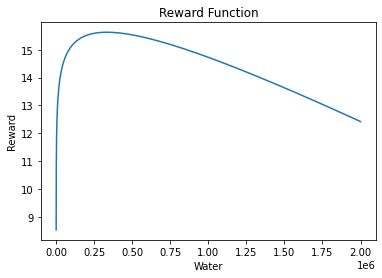

In [21]:
config = SimConfig()
env = SimulationCES(config)

env.plot_reward()

It initially appears that agents find solutions around the maximum.

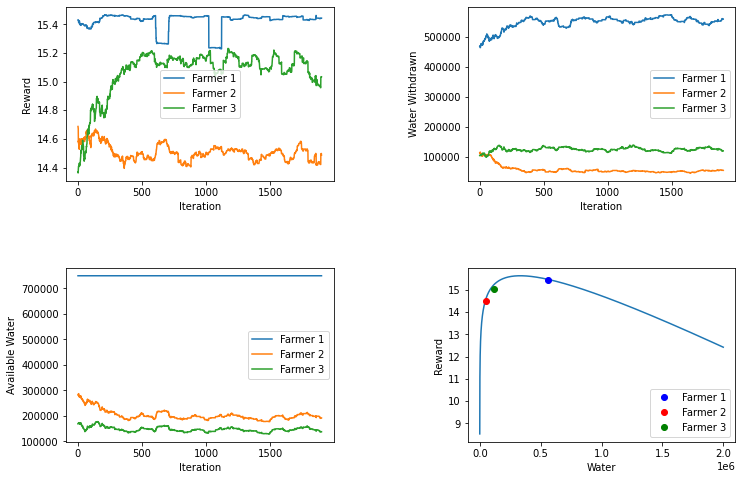

In [22]:
for i_episode in range(1, env.num_years + 1):
    env.step()
env.plot_summary()

## Questions

1. What variance around the reward and behavior of these solutions

1. Howitt, Richard E., Duncan MacEwan, Josué Medellín-Azuara, and Jay R. Lund. "Economic modeling of agriculture and water in California using the statewide agricultural production model." Davis, CA: University of California (2010).

2. Mnih, Volodymyr, Koray Kavukcuoglu, David Silver, Alex Graves, Ioannis Antonoglou, Daan Wierstra, and Martin Riedmiller. "Playing atari with deep reinforcement learning." arXiv preprint arXiv:1312.5602 (2013).

3. Schaul, Tom, John Quan, Ioannis Antonoglou, and David Silver. "Prioritized experience replay." arXiv preprint arXiv:1511.05952 (2015).



# Rethinking the Simulated Environment
---

There are three components to the simulated environment.
1. production function
2. reward function
3. hydrology function

Marco and I mainly discussed the simulated environment and how to best model it.
After our meeting, I think it will be beneficial to significantly change the first and third components.
Changing two components leads to rethinking the reward function. Bellow we will examine the previous version of each
component and the proposed changes.

Lastly, Marco argued that the simulation should operate at the timescale of one year to integrate appropriately
with the new production function and to make the simulation more tractable within the scope of a master's thesis.

## 1. Production function
In the past iteration the production function was a biologically based function with water/day as input and growth/day
as output. Marco recommended changing the production function to an economically based production function.
This serves two purposes. It simplifies calibrating the production function to real world data and, as we will see in the
next section, it will integrate better with the reward function.

### Old production function:
$$ Q = K *log(x_{water})$$

$K = $ production constant for scaling

$x_{water} = $ amount of water applied to the crop

### New Production Function: Constant Elasticity of Substitution (CES)

CES is an aggregation production function with two or more production inputs that have some
elasticity of substitution.

$$ Q_i = \pi_i (\beta_{land} * x^\rho_{land} + \beta_{water} * x^\rho_{water})^{r/\rho} $$

$$ \beta_{land} + \beta_{water} = 1 $$

$ Q_i =$ quantity of output, pounds of crop $i$

$\pi_i = $ factor productivity, normalizes units, from real world data

$\beta = $ share parameter, measures how important each input is, from real world data

$\rho = $ substitution parameter, how willing is the agent to swap $x_{land}$ for $x_{water}$, from real world data

$r = $ returns to scale, does crop $ i $ have economies of scale, from real world data

$ x_{input} = $ quantity of given input, agents action space

### What will change

old state vector:

- available_water
- CropWater_n
- CropGrowth_n
- CropPrices_n

new state vector:

- available_water
- available_land
- one_hot_available_crops_vector
- crop price vector

Possible additions:
- Hidden state vector

old action vector:
- water for each crop

new action vector:
- water for each crop
- land for each crop

I would love to hear your feedback on the state vector. Does it make sense to have the previous land crop and reward?
This is reminiscent of an LSTM but is also somewhat similar to the occasional myopic view of farmers.

The production function Could also add additional inputs such as fertilizer ect.

## 2. Reward Function

Since this new production function returns weights for each crop, with a given price/weight we can calculate the reward
in dollars. Not so interesting. The more interesting result is that if dollars are our return scalar, then all other rewards
must be stated in dollars. For example, if we want to incorporate a return for leaving water in the river for the farmer
downstream farmer or for the ecological health of the river, we need to state that reward in dollars. To do this, Marco
recommended I use another economic concept called a shadow price. A shadow price aims to put a dollar value on the
externalities for a given action or good. I have not looked into what real world values for this look like, but it wil be the first step after
getting a minimum viable simulation.

## 3. Hydrology function

The main change to the hydrology function comes from the change in the time step for each episode. Since we switch to
a yearly interval for the production function, we need to change the hydrology model to switch to a yearly function that
still incorporate stochastic water supply.

Old hydrology function:

$$ W_t = A * sin(\omega t + \phi) $$

A standard oscillation formula.

New hydrology function:

$$ W_t \in P(W \vert L_{ocation}) $$

Now we sample from a distribution given some geographic location where the distribution is derived from real world data.


This will allow us to do nice things once the agents are trained such as skew or change the distribution
to simulate changing water availability due to climate change or some other factor.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
class SimConfig:
    """
    This config class simplifies the initialization of the SimulationCES class.
    """

    def __init__(self):
        self.num_crops = 1

        # TODO: use a dictionary to hold these values for different watersheds, then access watershed values via init argument
        # hydrology function, current estimate based on lower Clark Fork
        self.water_mu = 3e6  # cfs
        self.water_sigma = 1e2  # cfs
        self.aquifer_volume = 0 #self.water_mu * 2  # cf

        # stochastic water dist
        self.water_dist = self.water_sigma * np.random.randn(100) + self.water_mu
        # # constant water dist
        # self.water_dist = np.full(100, self.water_mu)

        # simulation parameters
        self.number_farmers = 3
        self.farmer_priority = [0, 1, 2]
        # self.random_seed = 1 # seems like decent seed
        # self.random_seed = 5  # pathological seed
        self.random_seed = None

        # agent parameters
        # [available_water, available_land, crop_identity_vec, crop_price_vec]
        # FIXME: THIS WILL NEED TO CHANGE WHEN self.crop_list CHANGES TO ONE HOT VECTOR
        self.state_size = 3
        self.action_size = 2 * self.num_crops
        self.memory_size = 10

In [3]:
class Aquifer:
    # TODO: CURRENTLY THIS IS INCORPORATED IN THE SAME PRIORITY AS SURFACE WATER, CHANGING THIS MAY LEAD TO MORE INTERESTING DYNAMICS

    def __init__(self, initial_volume):
        self.available_volume = initial_volume
        self.recharge_mu = initial_volume * 0.1
        self.recharge_sigma = self.recharge_mu * 0.3

    def withdraw_water(self, amount):
        """
        Withdraws water from the aquifer.
        Currently allows for complete draining of the aquifer but prevents negative values.

        Amount in the aquifer is unknown to the farmer and therefore is not in the agent's state vector.
        :param amount: attempted water withdrawal
        :return: actual amount withdrawn
        """
        if amount < self.available_volume:
            self.available_volume -= amount

            return amount

        else:
            amount = self.available_volume
            self.available_volume = 0

            return amount

    def recharge_aquifer(self):
        """
        Stochastic recharge of the aquifer.
        Currently based in independent distribution but could be tied to surface water.
        :return: None
        """
        self.available_volume += np.random.randn() * self.recharge_sigma + self.recharge_mu

        return None

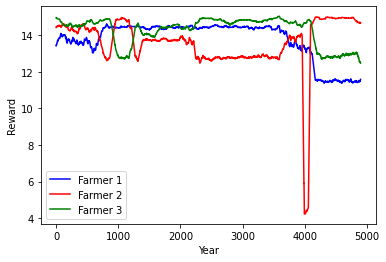

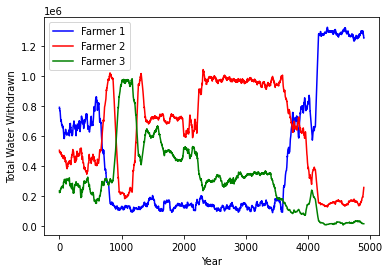

In [6]:
# from simulation_project.CES_Ag_agent import Agent
from simulation_project.prioritized_dqn_agent import Agent

class SimulationCES:
    """
    Simulation environment utilizing CES production funtion
    """

    def __init__(self, config: SimConfig):
        # simulation configuration
        self.config = config

        # simulation records for analysis
        self.farmers_rewards_record = [[] for _ in range(config.number_farmers)]
        self.water_record = {"Aquifer": [],
                             "Surface": []}
        self.farmers_water_withdrawal_record = [[] for _ in range(config.number_farmers)]
        self.farmers_actions_record = [[] for _ in range(config.number_farmers)]
        self.farmer_available_water_record = [[] for _ in range(config.number_farmers)]

        # simulation parameters
        self.num_farmers = config.number_farmers
        self.farmer_priority = config.farmer_priority
        self.farmer_list = [Agent(config.state_size, config.action_size, config.random_seed) for _ in
                            range(self.num_farmers)]
        self.year = 1

        # simulation functions, reward function is a property
        self.hydrology_function = config.water_dist
        self.aquifer = Aquifer(config.aquifer_volume)

        # initialize river continuum
        self.source_water = self.init_available_water()
        self.available_water = [self.source_water for _ in range(self.num_farmers)]

        # land available to each farmer
        # FIXME: MAKE THIS COME FROM CONFIG FILE?
        self.available_land = [100 for _ in range(self.num_farmers)]

        # production function parameters
        self.crop_1 = {"pi": 10,
                       "beta_land": 0.5,
                       "beta_water": 0.5,
                       "rho": 1,
                       "r": 1}
        # self.crop_2 = {"pi": 10,
        #                "beta_land": 0.3,
        #                "beta_water": 0.7,
        #                "rho": 1,
        #                "r": 1}

        # TODO: THESE NEED TO GO INTO THE CONFIG CLASS
        self.crop_1_price = 10
        self.crop_prices = [self.crop_1_price]

    def reset(self):
        """
        Resets the simulation environment. Open AI Gym interface.

        Only the river continuum needs to be reset each episode.
        Everything else needs to persist between episodes. I think...

        Returns: None
        """

        # recharge aquifer
        self.aquifer.recharge_aquifer()

        # re-initialize available water, this includes surface and aquifer
        self.source_water = self.init_available_water()
        self.available_water = [self.source_water for _ in range(self.num_farmers)]

        return None

    def reward_function(self, action):

        x1_water, x1_land = action

        """input amounts are the action space for the agents"""
        q_1 = self.crop_1["pi"] * (
                    self.crop_1["beta_land"] * (x1_land ** self.crop_1["rho"]) + self.crop_1["beta_water"] * (
                        x1_water ** self.crop_1["rho"])) ** (self.crop_1["r"] / self.crop_1["rho"])

        # calc rewards, add 1e-6 for numeric stability
        r_1 = np.log(q_1 * self.crop_1_price + 1e-6)

        land_cost = self.land_cost_function(x1_land)
        water_cost = self.water_cost_function(x1_water)
        total_cost = land_cost + water_cost

        # TODO: EXPAND THIS, it needs to be temporally correlated
        shadow_price = 0

        return r_1 - total_cost - shadow_price

    # def reward_function(self, action):
    #     water, land = action
    #     reward = 0
    #     if 1.5e6 > water >= 1.0e6:
    #         reward += 100
    #     else:
    #         reward -= 10
    #
    #     return reward

    def water_cost_function(self, total_water):
        """
        Non-Monotonic cost function for water.
        Currently assumes that each land use has equivalent costs.


        :param total_water:
        :return: total water cost
        """

        w_0 = 5e-6

        cost = w_0 * total_water

        return cost

    def land_cost_function(self, total_land):
        """
        Non-Monotonic cost function for land.
        Currently assumes that each land use has equivalent costs.


        :param total_land: total land used by the farmer for both crops.
        :return: total land cost
        """
        w_0 = 5e-6

        cost = w_0 * total_land

        return cost

    def plot_reward(self, crop):

        # TODO: MAKE THIS FLEXIBLE TO PLOT DIFFERENT CROPS

        # crop 1
        x_len = int(2e6)
        # water crop 1
        water = np.arange(x_len) + 1
        # water crop 2
        # water = np.stack((water, np.zeros(x_len)), axis=-1)

        # land crop 1, 100 total units available land for both crops
        land = np.full(x_len, 100)

        # land crop 2
        # land = np.stack((land, np.zeros(x_len)), axis=-1)

        # combine water and land
        action_vec = np.stack((water, land), axis=-1)

        y = []
        for action in action_vec:
            y.append(self.reward_function(action))

        x = action_vec[:, 0]

        plt.title("Reward Function")
        plt.xlabel("Water")
        plt.ylabel("Reward")
        plt.plot(x, y)
        plt.show()

        return None

    def init_available_water(self):
        """
        Initializes available water for beginning of episode.
        Pulls random sample from historic discharge distribution.

        This needs to be a function call so that we get a new random number each time we want to initialize
        a seasons available water.

        Returns: (float) available water.
        """
        # get initial values for water types
        surface_water = np.random.choice(self.hydrology_function)
        aquifer = self.aquifer.available_volume

        # update water records
        self.water_record["Surface"].append(surface_water)
        self.water_record["Aquifer"].append(aquifer)

        return surface_water + aquifer

    def update_available_water(self, priority_index, action):
        """
        Updates all available water down stream from agent indicated by priority index.

        Args:
            priority_index: indicates at what point in the river continuum to update flows
            action: amount of water removed by agent
        """
        # determine the total water removed
        total_removed = action[0]
        self.farmers_water_withdrawal_record[priority_index].append(total_removed)

        # remove water from aquifer
        aquifer_removed = self.aquifer.withdraw_water(total_removed / 2)

        # determine how much water needs to come from surface water
        surface_removed = total_removed - aquifer_removed

        # remove water from surface continuum, max operation prevents negative water amounts
        for i in range(priority_index, len(self.available_water)):
            self.available_water[i] = max(self.available_water[i] - surface_removed, 1e-3)

        return None

    def step(self):
        """
        Takes a step in the environment and updates all relevant instance attributes.

        This will look a little different than most other RL training loops for two reasons:
        1. This is inherently a multi agent system
        2. There is only one step in each episode

        Returns: None
        """

        # iterate through farmers in their priority order
        for priority_num in self.farmer_priority:
            agent = self.farmer_list[priority_num]
            state = np.concatenate((
                [self.available_water[priority_num]],
                [self.available_land[priority_num]],
                self.crop_prices)
            )

            # record available water for this farmer
            self.farmer_available_water_record[priority_num].append(self.available_water[priority_num])

            # get action, and record actions for debugging
            action = agent.act(state)
            self.farmers_actions_record[priority_num].append(action)

            reward = self.reward_function(action)
            self.update_available_water(priority_num, action)

            # save reward for later analysis
            self.farmers_rewards_record[priority_num].append(reward)

            # estimate next action and save state information in agent memory
            next_state = np.concatenate((
                [self.available_water[priority_num]],
                [self.available_land[priority_num]],
                self.crop_prices)
            )
            agent.step(state, action, reward, next_state, True)


        # 1 year of simulation complete, reset the source water
        self.reset()
        self.year += 1


# for debugging
config = SimConfig()
config.farmer_priority = [0,1,2]
env = SimulationCES(config)

num_years = 5000

for i_episode in range(1, num_years + 1):
    env.step()

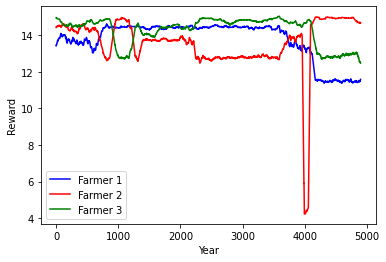

In [8]:
# red and green should be screwed

plt.xlabel("Year")
plt.ylabel("Reward")

average_rewards = []
for i, record in enumerate(env.farmers_rewards_record):
    average_rewards.append(np.convolve(record, np.ones(100), 'valid') / 100)

plt.plot(np.arange(len(average_rewards[0])), average_rewards[0], 'b-', label="Farmer 1")
plt.plot(np.arange(len(average_rewards[1])), average_rewards[1], 'r-', label="Farmer 2")
plt.plot(np.arange(len(average_rewards[2])), average_rewards[2], 'g-', label="Farmer 3")

plt.legend()
plt.show()

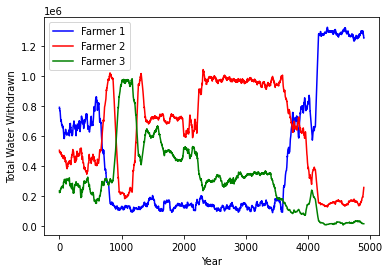

In [9]:
plt.xlabel("Year")
plt.ylabel("Total Water Withdrawn")

average_water_withdrawal = []
for i, record in enumerate(env.farmers_water_withdrawal_record):
    average_water_withdrawal.append(np.convolve(record, np.ones(100), 'valid') / 100)

plt.plot(np.arange(len(average_water_withdrawal[0])), average_water_withdrawal[0], 'b-', label="Farmer 1")
plt.plot(np.arange(len(average_water_withdrawal[1])), average_water_withdrawal[1], 'r-', label="Farmer 2")
plt.plot(np.arange(len(average_water_withdrawal[2])), average_water_withdrawal[2], 'g-', label="Farmer 3")
plt.legend()
plt.show()

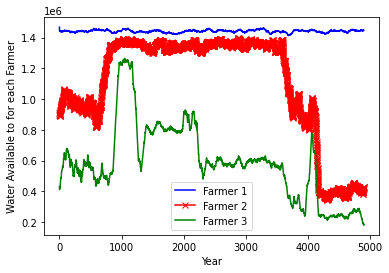

In [10]:
plt.xlabel("Year")
plt.ylabel("Water Available to for each Farmer")

average_available_water = []
for i, record in enumerate(env.farmer_available_water_record):
    average_available_water.append(np.convolve(record, np.ones(100), 'valid') / 100)

plt.plot(np.arange(len(average_available_water[0])), average_available_water[0], 'b-', label="Farmer 1")
plt.plot(np.arange(len(average_available_water[1])), average_available_water[1], 'rx-', label="Farmer 2")
plt.plot(np.arange(len(average_available_water[2])), average_available_water[2], 'g-', label="Farmer 3")
plt.legend()
plt.show()

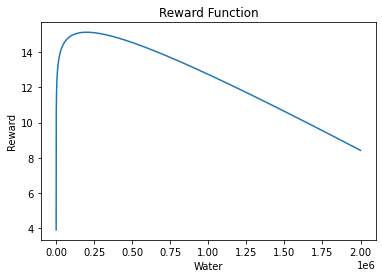

In [5]:
config = SimConfig()
test_env = SimulationCES(config)

test_env.plot_reward(crop="crop 1")


The observed noise in the reward is due to the stochastic nature of the available water distribution.
In the config class you can switch between a constant water distribution, and a stochastic distribution to observe this.


In [ ]:
# green should be screwed

config = SimConfig()
config.farmer_priority = [1,0,2]
env = SimulationCES(config)

num_years = 15

for i_episode in range(1, num_years + 1):
    env.step()

plt.xlabel("Year")
plt.ylabel("Reward")
plt.plot(np.arange(env.year - 1), env.farmers_rewards_record[0], 'bo', label="Farmer 1")
plt.plot(np.arange(env.year - 1), env.farmers_rewards_record[1], 'r-', label="Farmer 2")
plt.plot(np.arange(env.year - 1), env.farmers_rewards_record[2], 'g-', label="Farmer 3")
plt.legend()
plt.show()

In [ ]:
# red should be screwed

config = SimConfig()
config.farmer_priority = [2,0,1]
env = SimulationCES(config)

num_years = 15

for i_episode in range(1, num_years + 1):
    env.step()

plt.xlabel("Year")
plt.ylabel("Reward")
plt.plot(np.arange(env.year - 1), env.farmers_rewards_record[0], 'b-', label="Farmer 1")
plt.plot(np.arange(env.year - 1), env.farmers_rewards_record[1], 'r-', label="Farmer 2")
plt.plot(np.arange(env.year - 1), env.farmers_rewards_record[2], 'g-', label="Farmer 3")
plt.legend()
plt.show()

In [ ]:
# no body should be screwed

config = SimConfig()
config.farmer_priority = [2,1,0]
env = SimulationCES(config)

num_years = 15

for i_episode in range(1, num_years + 1):
    env.step()

plt.xlabel("Year")
plt.ylabel("Reward")
plt.plot(np.arange(env.year - 1), env.farmers_rewards_record[0], 'b-', label="Farmer 1")
plt.plot(np.arange(env.year - 1), env.farmers_rewards_record[1], 'r-', label="Farmer 2")
plt.plot(np.arange(env.year - 1), env.farmers_rewards_record[2], 'g-', label="Farmer 3")
plt.legend()
plt.show()

The rewards should be reversed from what they are. There must be another bug somewhere in the simulation.

TODO:

1. simplify down to one farmer and one crop to make sure that the alg can find the max
1. add simulation members to debug the reversed trend observed in the behavior from plots
2. add in a regulatory agent
3. adjust aquifer recharge rate
4. incorporate the data from Marco's student, at least means first


In [ ]:
# # test to make sure reward function was getting correct informaiton
# farmer_1, farmer_2, farmer_3 = env.farmers_actions_record
# farmer_1_y = []
# for action in farmer_1:
#     farmer_1_y.append(env.reward_function(action))
#
# farmer_3_y = []
# for action in farmer_3:
#     farmer_3_y.append(env.reward_function(action))
#
# x = np.arange(15)
# plt.plot(x, farmer_1_y, label="Farmer 1")
# plt.plot(x, farmer_3_y, label="Farmer 3")
# plt.legend()
# plt.show()

